In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Conv2D, MaxPooling2D, Reshape, Lambda, Permute
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import clear_session
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def clean_text(tweet):
    #remove emoji
    emoji = re.compile("["
                        u'\U0001F600-\U0001F64F'  # emoticons
                        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                        u'\U0001F680-\U0001F6FF'  # transport & map symbols
                        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
                        u'\U00002702-\U000027B0'
                        u'\U000024C2-\U0001F251'
                        "]+", flags=re.UNICODE)
    tweet = emoji.sub(r'', tweet)

    #remove punctuation
    punctuation = '''!\(\)-\[]\{};:'"\,<>./?@#$%^&*_~=+…''' + u'\u060C' + u'\u061B' + u'\u061F'
    for c in tweet:
        if c in punctuation:
            tweet = tweet.replace(c, '')

    #remove laughter
    laughter = re.compile(r'\b(ه|خ)\1{2,}\b')
    tweet = laughter.sub('', tweet)

    #remove nonsense
    nonsense = re.compile(r'\b(.)\1{2,}\b')
    tweet = nonsense.sub(r'', tweet)

    #normalize elongated words
    repeated_characters = re.compile(r'(.)\1{2,}')
    tweet = repeated_characters.sub(r'\1', tweet)

    return tweet

clean_text = np.vectorize(clean_text)

---

# Data Preprocessing

In [0]:
url = 'https://raw.githubusercontent.com/Hala-Mulki/L-HSAB-First-Arabic-Levantine-HateSpeech-Dataset/master/Dataset/L-HSAB'
lhsab = pd.read_csv(url, sep='\t')

In [0]:
lhsab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5846 entries, 0 to 5845
Data columns (total 2 columns):
Tweet    5846 non-null object
Class    5846 non-null object
dtypes: object(2)
memory usage: 91.5+ KB


---

**Checking for Dataset Imbalance**

In [0]:
lhsab['Class'].value_counts()

normal     3650
abusive    1728
hate        468
Name: Class, dtype: int64

---

**Data Preparation**

In [0]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 280

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=False)
tokenizer.fit_on_texts(clean_text(lhsab['Tweet'].values))
VOCAB_SIZE = len(tokenizer.word_index) + 1
word_list = list(tokenizer.word_index.keys())

X = tokenizer.texts_to_sequences(clean_text(lhsab['Tweet'].values))
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

y = pd.get_dummies(lhsab['Class'].values)
label_names = y.columns
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4676, 280) (4676, 3)
(1170, 280) (1170, 3)


In [0]:
print(word_list)

['يا', 'من', 'جبران', 'ما', 'باسيل', 'و', 'في', 'على', 'انت', 'لا', 'شو', 'بس', 'الله', 'كل', 'عن', 'عم', 'لبنان', 'مش', 'مع', 'ولا', 'هوا', 'وهاب', 'كول', 'هو', 'شي', 'كان', 'ان', 'قطر', 'الوزير', 'اذا', 'كلب', 'لو', 'هذا', 'يلي', 'مين', 'واحد', 'ع', 'هيك', 'متل', 'انو', 'سوريا', 'وئام', 'الى', 'أن', 'عليك', 'وزير', 'والله', 'حدا', 'او', 'روح', 'هيدا', 'اللي', 'بعد', 'الرئيس', 'بدك', 'بلا', 'هل', 'انا', 'كيف', 'عون', 'دولة', 'عثمان', 'يعني', 'لك', 'ابو', 'غير', 'لازم', 'قال', 'منك', 'رح', 'كنت', 'الا', 'وما', 'حمار', 'حق', 'قبل', 'ابن', 'إلى', 'العربية', 'لي', 'بشار', 'وانت', 'القمة', 'انك', 'هي', 'الحريري', 'حتى', 'أو', 'الخارجية', 'اسرائيل', 'تحكي', 'ولك', 'البلد', 'وين', 'خراس', 'السيد', 'معالي', 'رئيس', 'لما', 'فيه', 'سعد', 'الناس', 'بدو', 'حالك', 'صار', 'ليش', 'يلعن', 'الحق', 'الي', 'حزب', 'معك', 'يكون', 'شيخ', 'كتير', 'العرب', 'ب', 'فيك', 'حسن', 'كلاب', 'طيب', 'انه', 'الدولة', 'لم', 'قاتل', 'يوم', 'راسك', 'وليد', 'تكون', 'عند', 'مثل', 'شعب', 'الذي', 'كلام', 'عنا', 'الشيخ', 'بين'

**Loading AraVec**

In [0]:
aravec = gensim.models.Word2Vec.load('/content/drive/My Drive/Neural Networks Project/tweets_sg_100/tweets_sg_100')

embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    if word in aravec.wv.vocab:
        embedding_matrix[i] = aravec.wv.word_vec(word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
aravec.wv.most_similar('خنزير')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('وخنزير', 0.7945762872695923),
 ('نجس', 0.7852752208709717),
 ('مجوسي', 0.7615289688110352),
 ('البغل', 0.7574300765991211),
 ('خنازير', 0.7564376592636108),
 ('الجحش', 0.7463150024414062),
 ('النجس', 0.7462490797042847),
 ('وكلب', 0.7312673926353455),
 ('جرذ', 0.7243212461471558),
 ('الكلب', 0.7241082191467285)]

In [0]:
aravec.wv.most_similar('عاهر')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('داعر', 0.7564408779144287),
 ('معتوه', 0.747181236743927),
 ('منحط', 0.7423575520515442),
 ('ومنافق', 0.7298714518547058),
 ('نجس', 0.728484034538269),
 ('شاذ', 0.7253782153129578),
 ('ومتخلف', 0.7215023040771484),
 ('ومنحط', 0.7192544937133789),
 ('زنديق', 0.7085251808166504),
 ('خسيس', 0.6997836232185364)]

In [0]:
aravec.wv.most_similar('بهيم')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('بغل', 0.6742550730705261),
 ('هبيله', 0.6707864999771118),
 ('ومعرص', 0.6680583953857422),
 ('مخو', 0.6537748575210571),
 ('قذافي', 0.644923746585846),
 ('زلمي', 0.6406307220458984),
 ('شادها', 0.6402127742767334),
 ('زلمه', 0.6397022604942322),
 ('ماكش', 0.6361751556396484),
 ('اهبل', 0.6354578137397766)]

In [0]:
aravec.wv.most_similar('تيار')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('وتيار', 0.7635721564292908),
 ('تكتل', 0.7617678642272949),
 ('التقدمي', 0.7359667420387268),
 ('انتخابي', 0.7192368507385254),
 ('فصيل', 0.7143242359161377),
 ('الاصلاح', 0.7101719379425049),
 ('سياسي', 0.7094211578369141),
 ('والاصلاح', 0.709301233291626),
 ('ايديولوجي', 0.7088208794593811),
 ('لتيار', 0.7064974904060364)]

In [0]:
aravec.wv.most_similar('داعش')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('الصحوات', 0.8500247597694397),
 ('الدواعش', 0.8475117683410645),
 ('النصره', 0.8457817435264587),
 ('المليشيات', 0.8329477906227112),
 ('داعش»', 0.831871747970581),
 ('الارهابين', 0.8304831981658936),
 ('تنظيم', 0.8277500867843628),
 ('الفلوجه', 0.8274105787277222),
 ('دواعش', 0.8157409429550171),
 ('الحشد', 0.8132305145263672)]

**Data Oversampling**

In [0]:
%%capture
#oversample = SVMSMOTE(random_state=24)
#X_res, y_res = oversample.fit_resample(X_train, np.argmax(y_train, axis=1))
#y_res = pd.get_dummies(y_res).values

---

# Naive Bayes

In [0]:
count_vect = CountVectorizer(lowercase=False)
X_counts = count_vect.fit_transform(lhsab['Tweet'])
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_counts)
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, lhsab['Class'], test_size=0.2, random_state=42, stratify=y)
print(X_tfidf_train.shape, y_tfidf_train.shape)
print(X_tfidf_test.shape, y_tfidf_test.shape)

(4676, 20761) (4676,)
(1170, 20761) (1170,)


In [0]:
pd.Series(y_tfidf_test).value_counts()

normal     730
abusive    346
hate        94
Name: Class, dtype: int64

In [0]:
pd.Series(y_tfidf_train).value_counts()

normal     2920
abusive    1382
hate        374
Name: Class, dtype: int64

In [0]:
sample_weights = compute_sample_weight('balanced', y_tfidf_train)
nb = MultinomialNB()
nb.fit(X_tfidf_train, y_tfidf_train, sample_weight=sample_weights)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_tfidf_pred = nb.predict(X_tfidf_test)
print(classification_report(y_tfidf_test, y_tfidf_pred))

              precision    recall  f1-score   support

     abusive       0.61      0.65      0.63       346
        hate       0.32      0.70      0.44        94
      normal       0.89      0.73      0.80       730

    accuracy                           0.70      1170
   macro avg       0.61      0.69      0.62      1170
weighted avg       0.76      0.70      0.72      1170



---

# Bidirectional LSTM

In [0]:
EMBEDDING_DIM = 100

def create_model(dropout_rate=0.8, lstm_dropout=0.2, nb_lstm=2, lstm_units=16, dense_units=16, nb_dense=0):
    clear_session()
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(Dropout(dropout_rate))
    for i in range(nb_lstm):
        model.add(Bidirectional(LSTM(lstm_units , dropout=lstm_dropout, return_sequences=True)))
        model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units, dropout=lstm_dropout, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    for i in range(nb_dense):
        model.add(Dense(dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

parameters = {
    'dropout_rate' : [0.2, 0.5, 0.8],
    'lstm_dropout' : [0.2, 0.5, 0.8],
    'nb_lstm' : [1, 2, 3, 4],
    'lstm_units' : [8, 16, 32],
    'dense_units' : [8, 16, 32],
    'nb_dense' : [0, 1, 2],
    'batch_size' : [100, 500, 1000],
    'epochs' : [20, 40, 60]
}

clf = RandomizedSearchCV(estimator=model, param_distributions=parameters, random_state=29)

class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

clf.fit(X_train, y_train, class_weight=class_weights, verbose=0)

In [0]:
print(f"best score is {clf.best_score_}, best parameter from grid search is{clf.best_params_}")

best score is 0.7290417909622192, best parameter from grid search is{'nb_lstm': 1, 'nb_dense': 0, 'lstm_units': 8, 'lstm_dropout': 0.2, 'epochs': 60, 'dropout_rate': 0.8, 'dense_units': 8, 'batch_size': 100}


---

In [0]:
bilstm_cv = load_model('/content/drive/My Drive/Neural Networks Project/bilstm_cv.h5')
bilstm_cv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 100)          2094700   
_________________________________________________________________
dropout (Dropout)            (None, 280, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 280, 16)           6976      
_________________________________________________________________
dropout_1 (Dropout)          (None, 280, 16)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 5

In [0]:
y_pred = np.argmax(bilstm_cv.predict(X_test, batch_size=1), axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

              precision    recall  f1-score   support

     abusive       0.65      0.63      0.64       346
        hate       0.40      0.52      0.45        94
      normal       0.82      0.80      0.81       730

    accuracy                           0.72      1170
   macro avg       0.62      0.65      0.63      1170
weighted avg       0.73      0.72      0.73      1170



---

# Bidirectional LSTM with AraVec CV

In [0]:
EMBEDDING_DIM = 100
EPOCHS = 60
BATCH = 100

clear_session()
bilstm_aravec_cv = Sequential()
bilstm_aravec_cv.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True))
bilstm_aravec_cv.add(Dropout(0.8))
bilstm_aravec_cv.add(Bidirectional(LSTM(8, dropout=0.2, return_sequences=False)))
bilstm_aravec_cv.add(Dropout(0.8))
bilstm_aravec_cv.add(Dense(3, activation='softmax'))

class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

checkpoint = ModelCheckpoint('/content/drive/My Drive/Neural Networks Project/bilstm_aravec_cv.h5', monitor='val_loss', verbose=0, save_best_only=True)

bilstm_aravec_cv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = bilstm_aravec_cv.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=0.2, class_weight=class_weights, callbacks=[checkpoint])

Epoch 1/60
38/38 [==============================] - 3s 79ms/step - loss: 1.1430 - accuracy: 0.3882 - val_loss: 1.0563 - val_accuracy: 0.5641
Epoch 2/60
38/38 [==============================] - 2s 52ms/step - loss: 1.1116 - accuracy: 0.3537 - val_loss: 1.0695 - val_accuracy: 0.5118
Epoch 3/60
38/38 [==============================] - 2s 54ms/step - loss: 1.1081 - accuracy: 0.3588 - val_loss: 1.0481 - val_accuracy: 0.6004
Epoch 4/60
38/38 [==============================] - 2s 51ms/step - loss: 1.1111 - accuracy: 0.3487 - val_loss: 1.0650 - val_accuracy: 0.5374
Epoch 5/60
38/38 [==============================] - 2s 54ms/step - loss: 1.0987 - accuracy: 0.3476 - val_loss: 1.0403 - val_accuracy: 0.6132
Epoch 6/60
38/38 [==============================] - 2s 51ms/step - loss: 1.0884 - accuracy: 0.4182 - val_loss: 1.0433 - val_accuracy: 0.6111
Epoch 7/60
38/38 [==============================] - 2s 54ms/step - loss: 1.0752 - accuracy: 0.4201 - val_loss: 1.0325 - val_accuracy: 0.6496
Epoch 8/60
38

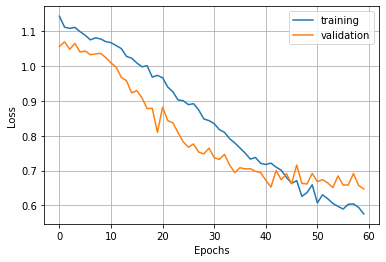

In [0]:
plt.figure()
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [0]:
bilstm_aravec_cv = load_model('/content/drive/My Drive/Neural Networks Project/bilstm_aravec_cv.h5')
y_pred = np.argmax(bilstm_aravec_cv.predict(X_test, batch_size=1), axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

              precision    recall  f1-score   support

     abusive       0.70      0.63      0.67       346
        hate       0.56      0.47      0.51        94
      normal       0.83      0.89      0.86       730

    accuracy                           0.78      1170
   macro avg       0.70      0.66      0.68      1170
weighted avg       0.77      0.78      0.77      1170



# CNN-LSTM

In [0]:
#Tunable (These values are after tuning)
dropout_rate = 0.8
lstm_dropout = 0.7
lstm_units = 20
nb_filters = 64
filter_size = 3


#Architecture
EMBEDDING_DIM = 100
clear_session()
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix]))
model.add(Permute((2,1), input_shape = (MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))
model.add(Lambda(lambda t: t[..., None]))
model.add(Conv2D(nb_filters, (100,filter_size), input_shape=(EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, 1), name = 'Conv'))
model.add(MaxPooling2D(pool_size= model.get_layer('Conv').output_shape[1:3]))
model.add(Dropout(dropout_rate))
model.add(Reshape((1, nb_filters)))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dropout(lstm_dropout))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 100)          2094700   
_________________________________________________________________
permute (Permute)            (None, 100, 280)          0         
_________________________________________________________________
lambda (Lambda)              (None, 100, 280, 1)       0         
_________________________________________________________________
Conv (Conv2D)                (None, 1, 278, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 64)          0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 64)             0

In [0]:
e = 20
batch_size = 256

class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

checkpoint = ModelCheckpoint('/content/drive/My Drive/Neural Networks Project/CNN-lstm_aravec_cv.h5', monitor='val_loss', verbose=0, save_best_only=True)

history = model.fit(X_train, y_train, class_weight=class_weights, validation_split=0.2, verbose=10, epochs = e, batch_size = batch_size, callbacks=[checkpoint])

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


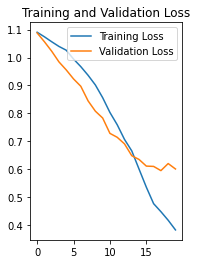

Confusion Matrix
[[231  52  63]
 [ 30  51  13]
 [ 66  40 624]]
              precision    recall  f1-score   support

     abusive       0.71      0.67      0.69       346
        hate       0.36      0.54      0.43        94
      normal       0.89      0.85      0.87       730

    accuracy                           0.77      1170
   macro avg       0.65      0.69      0.66      1170
weighted avg       0.79      0.77      0.78      1170



In [0]:
#acc = history.history['acc']
#val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(e)

#plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
#plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
#plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

y_pred = np.argmax(model.predict(X_test, batch_size=1), axis=1)

print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))